# Convolutional Neural Network

Modified from Tensorflow time series example

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Read csv raw data

In [2]:
df=pd.read_csv('well_2520data_v1.csv')

Let's take a glance at the data.

In [3]:
df.shape

(2520, 16)

In [4]:
df.head()

,Date,Gas Flow_MMSCFD,Oil_bpd,Water_bpd,FWHP_psig,FroudeNumberGas6,FroudeNumberLiquid6,HoldupFractionLiquid6,ReynoldsNumber6,SuperficialVelocityGas6,SuperficialVelocityLiquid6,SurfaceTensionLiquidInSitu6,ViscosityLiquidInSitu6,FlowPatternGasLiquid6,FINAPRESS,FINATEMP
0,1/1/2020,1.997999,466.86395,4320.80866,5603.811198,0.080394,0.799680,0.839809,396646.0544,0.513819,2.540583,0.013141,0.273806,4,2150.835786,211.852508
1,1/2/2020,2.000979,462.75264,3177.54154,5574.183600,0.079922,0.629477,0.811463,312421.2874,0.491906,1.980774,0.011881,0.276766,4,2284.109281,207.602074
2,1/3/2020,1.998964,448.63094,2587.33434,5547.496275,0.080651,0.537949,0.788673,268611.3109,0.484539,1.681916,0.011080,0.279040,4,2371.590019,204.256007
3,1/4/2020,1.985018,444.05424,2207.89845,5532.051609,0.079546,0.481507,0.775623,238882.5679,0.467621,1.496468,0.010385,0.281000,4,2439.152773,201.442625
4,1/5/2020,1.986000,428.11200,1983.00000,5525.004375,0.081171,0.443607,0.759974,221882.4547,0.469368,1.372262,0.009937,0.282733,4,2494.398480,199.322796


In [5]:
df.drop(columns='Date', inplace=True)

In [6]:
df2=pd.get_dummies(df['FlowPatternGasLiquid6'],prefix='FlowPattern')

In [7]:
df=pd.concat([df,df2],axis=1)

In [8]:
df.drop(columns='FlowPatternGasLiquid6', inplace=True)

In [9]:
df.head()

,Gas Flow_MMSCFD,Oil_bpd,Water_bpd,FWHP_psig,FroudeNumberGas6,FroudeNumberLiquid6,HoldupFractionLiquid6,ReynoldsNumber6,SuperficialVelocityGas6,SuperficialVelocityLiquid6,SurfaceTensionLiquidInSitu6,ViscosityLiquidInSitu6,FINAPRESS,FINATEMP,FlowPattern_3,FlowPattern_4
0,1.997999,466.86395,4320.80866,5603.811198,0.080394,0.799680,0.839809,396646.0544,0.513819,2.540583,0.013141,0.273806,2150.835786,211.852508,0,1
1,2.000979,462.75264,3177.54154,5574.183600,0.079922,0.629477,0.811463,312421.2874,0.491906,1.980774,0.011881,0.276766,2284.109281,207.602074,0,1
2,1.998964,448.63094,2587.33434,5547.496275,0.080651,0.537949,0.788673,268611.3109,0.484539,1.681916,0.011080,0.279040,2371.590019,204.256007,0,1
3,1.985018,444.05424,2207.89845,5532.051609,0.079546,0.481507,0.775623,238882.5679,0.467621,1.496468,0.010385,0.281000,2439.152773,201.442625,0,1
4,1.986000,428.11200,1983.00000,5525.004375,0.081171,0.443607,0.759974,221882.4547,0.469368,1.372262,0.009937,0.282733,2494.398480,199.322796,0,1


In [10]:
y_pre=df['FINAPRESS']      # Pressure label
X_pre=df.drop(columns=['FINAPRESS','FINATEMP'], axis=1) # Pressure data

In [11]:
y_hol=df['HoldupFractionLiquid6']     # holdup label
X_hol=df.drop(columns=['HoldupFractionLiquid6','FINATEMP'], axis=1)    # hold up data

In [12]:
X=df.iloc[:, 0:16]
y=df.iloc[:, 12]

In [13]:
y.head()

0    2150.835786
1    2284.109281
2    2371.590019
3    2439.152773
4    2494.398480
Name: FINAPRESS, dtype: float64

### Plot the raw data

In [14]:
def four_y_plot(paraa, labela, parab, labelb, parac, labelc, parad, labeld, labelx, title):
    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)
    
    fig, host = plt.subplots(figsize=(10, 8))
    fig.subplots_adjust(right=1)
    
    par1 = host.twinx()
    par2 = host.twinx()
    par3 = host.twinx()

    # Offset the right spine of par2.  The ticks and label have already been
    # placed on the right by twinx above.
    par2.spines["right"].set_position(("axes", 1.1))
    par3.spines["right"].set_position(("axes", 1.2))
    # Having been created by twinx, par2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par2)
    make_patch_spines_invisible(par3)
    # Second, show the right spine.
    par2.spines["right"].set_visible(True)
    par3.spines["right"].set_visible(True)
    
    p1, = host.plot(paraa, "b-", label=labela)
    p2, = par1.plot(parab, "r-", label=labelb)
    p3, = par2.plot(parac, "g-", label=labelc)
    p4, = par3.plot(parad, "black", label=labeld)
    
    # host.set_xlim(0, 250)
    # host.set_ylim(0, 2.2)
    # par1.set_ylim(0, 500)
    # par2.set_ylim(1, 5000)
    # par3.set_ylim(1, 6000)
    
    host.set_xlabel(labelx, fontsize=14)
    host.set_ylabel(labela, fontsize=14)
    par1.set_ylabel(labelb, fontsize=14)
    par2.set_ylabel(labelc, fontsize=14)
    par3.set_ylabel(labeld, fontsize=14)
    
    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())
    par3.yaxis.label.set_color(p4.get_color())
    
    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), labelsize=12)
    par1.tick_params(axis='y', colors=p2.get_color(), labelsize=12)
    par2.tick_params(axis='y', colors=p3.get_color(), labelsize=12)
    par3.tick_params(axis='y', colors=p4.get_color(), labelsize=12)
    host.tick_params(axis='x', labelsize=14)
 
    lines = [p1, p2, p3, p4]
    
    host.legend(lines, [l.get_label() for l in lines], fontsize=14)
    plt.title(title, fontsize=16)
    
    plt.show()
    

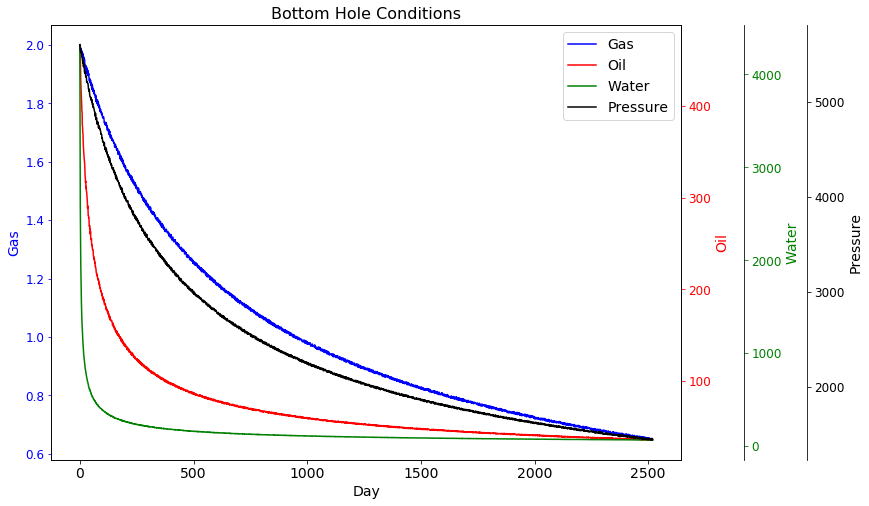

In [15]:
four_y_plot(df['Gas Flow_MMSCFD'], "Gas",
            df['Oil_bpd'], "Oil", 
            df['Water_bpd'],"Water",
            df['FWHP_psig'], "Pressure",
            "Day",
            "Bottom Hole Conditions")

### Reshape the input data

In both the following, the first 180 rows of the data will be the training dataset, and there remaining will be the validation dataset. 

In [16]:
TRAIN_VAL = 1700   #train and validation split
VAL_TEST=2016    #validation and test split

Setting seed to ensure reproducibility.

In [17]:
tf.random.set_seed(13)

Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [18]:
def create_time_steps(length):
  return list(range(-length, 0))

In [19]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i]) 
      #flattren() remove one layer of list'[]'
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be *the average of the last 20 observations*.

In [20]:
def baseline(history):
  return np.mean(history)

### CNN
Let's now use `tf.data` to shuffle, batch, and cache the dataset.

## Forecast a multivariate time series

Let's have a look at how each of these features vary across time.

As mentioned, the first step will be to standardize the dataset using the mean and standard deviation of the training data.

In [33]:
X.head()

,Gas Flow_MMSCFD,Oil_bpd,Water_bpd,FWHP_psig,FroudeNumberGas6,FroudeNumberLiquid6,HoldupFractionLiquid6,ReynoldsNumber6,SuperficialVelocityGas6,SuperficialVelocityLiquid6,SurfaceTensionLiquidInSitu6,ViscosityLiquidInSitu6,FINAPRESS,FINATEMP,FlowPattern_3,FlowPattern_4
0,1.997999,466.86395,4320.80866,5603.811198,0.080394,0.799680,0.839809,396646.0544,0.513819,2.540583,0.013141,0.273806,2150.835786,211.852508,0,1
1,2.000979,462.75264,3177.54154,5574.183600,0.079922,0.629477,0.811463,312421.2874,0.491906,1.980774,0.011881,0.276766,2284.109281,207.602074,0,1
2,1.998964,448.63094,2587.33434,5547.496275,0.080651,0.537949,0.788673,268611.3109,0.484539,1.681916,0.011080,0.279040,2371.590019,204.256007,0,1
3,1.985018,444.05424,2207.89845,5532.051609,0.079546,0.481507,0.775623,238882.5679,0.467621,1.496468,0.010385,0.281000,2439.152773,201.442625,0,1
4,1.986000,428.11200,1983.00000,5525.004375,0.081171,0.443607,0.759974,221882.4547,0.469368,1.372262,0.009937,0.282733,2494.398480,199.322796,0,1


In [34]:
dataset = X.values
data_mean = dataset[:TRAIN_VAL].mean(axis=0)
data_std = dataset[:TRAIN_VAL].std(axis=0)

In [35]:
dataset = (dataset-data_mean)/data_std

### Single step model (Predict current sequence '0' only, 'Future target' is 0)
In a single step setup, the model learns to predict a single point in the future based on some history provided.



In [37]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [38]:
past_history = 50
future_target = 0   # predict current. use 'past_history' points
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,12], 0,
                                                   TRAIN_VAL, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,12],
                                               TRAIN_VAL, VAL_TEST, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [39]:
x_test_single, y_test_single = multivariate_data(dataset, dataset[:,12],
                                               VAL_TEST, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [40]:
x_train_single.shape

(1600, 100, 16)

In [41]:
y_train_single.shape

(1600,)

In [42]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (100, 16)


In [45]:
x_train_single.shape

(1600, 100, 16)

Build the CNN model

In [131]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D 
from keras import optimizers


In [159]:


CNN_model = Sequential()
CNN_model.add(Conv1D(100, 3, activation='relu', input_shape=x_train_single.shape[-2:]))
CNN_model.add(Conv1D(100, 3, activation='relu'))
CNN_model.add(MaxPooling1D(3))
CNN_model.add(Conv1D(160, 3, activation='relu'))
CNN_model.add(Conv1D(160, 3, activation='relu'))
CNN_model.add(GlobalAveragePooling1D())
CNN_model.add(Dropout(0.1))
CNN_model.add(Dense(1))
print(CNN_model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 98, 100)           4900      
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 96, 100)           30100     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 32, 100)           0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 30, 160)           48160     
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 28, 160)           76960     
_________________________________________________________________
global_average_pooling1d_12  (None, 160)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 160)             

Let's check out a sample prediction.

In [160]:
CNN_model.compile(optimizer=optimizers.Adam(), loss='mae')

In [161]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint_name = 'CNNv1bestmodel.h5' 
mcp = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [162]:
CNN_history = CNN_model.fit(x_train_single, y_train_single, epochs=30,
                                            batch_size=50,
                                            validation_data=(x_val_single, y_val_single),
                                            callbacks=[mcp])

Train on 1600 samples, validate on 216 samples
Epoch 1/30
1600/1600 [==============================] - 1s 889us/step - loss: 0.1099 - val_loss: 0.0864

Epoch 00001: val_loss improved from inf to 0.08644, saving model to CNNv1bestmodel.h5
Epoch 2/30
1600/1600 [==============================] - 1s 732us/step - loss: 0.0534 - val_loss: 0.0857

Epoch 00002: val_loss improved from 0.08644 to 0.08569, saving model to CNNv1bestmodel.h5
Epoch 3/30
1600/1600 [==============================] - 1s 808us/step - loss: 0.0461 - val_loss: 0.0096

Epoch 00003: val_loss improved from 0.08569 to 0.00960, saving model to CNNv1bestmodel.h5
Epoch 4/30
1600/1600 [==============================] - 1s 760us/step - loss: 0.0508 - val_loss: 0.0275

Epoch 00004: val_loss did not improve from 0.00960
Epoch 5/30
1600/1600 [==============================] - 1s 750us/step - loss: 0.0408 - val_loss: 0.0726

Epoch 00005: val_loss did not improve from 0.00960
Epoch 6/30
1600/1600 [==============================] - 1s 8

In [91]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

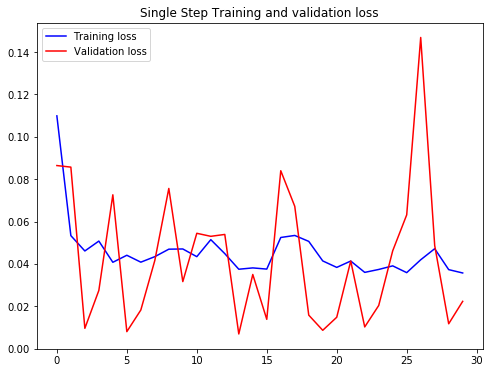

In [163]:
plot_train_history(CNN_history,
                   'Single Step Training and validation loss')

Load weights file

In [164]:

wights_file = 'CNNv1bestmodel.h5'
CNN_model.load_weights(wights_file) # load it
CNN_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mae', metrics=['mean_absolute_error'])

#### Predict a single step 


In [165]:
predictions=CNN_model.predict(x_test_single)

In [166]:
predictions=predictions*data_std[12]+data_mean[12]

In [96]:
y_test_single=y_test_single*data_std[12]+data_mean[12]

In [168]:
from sklearn import metrics

def CNN_comp_plot(dnn, testy, pred, labelx, labely, ftitle):
    # Look at the results
    lw = 2
    
    fig= plt.figure(figsize=(12, 10))
   
    y_hat=pred
        
    MAE=format(metrics.mean_absolute_error(testy, y_hat),'.3f')
    MSE=format(metrics.mean_squared_error(testy, y_hat),'.2f')
    R2=format(metrics.r2_score(testy, y_hat),'.4f')        
        
    plt.plot(y_hat, color='blue', lw=lw,
                      label='{} (MAE: {},  R^2: {})'.format(dnn, MAE, R2))
    plt.plot(testy, color='red', linestyle=':', lw=3,
                      label='Test data')                    
    plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),fontsize=12)
    plt.xlabel(labelx, fontsize=12)
    plt.ylabel(labely, fontsize=12)
    fig.suptitle(ftitle, fontsize=16)
    plt.show()

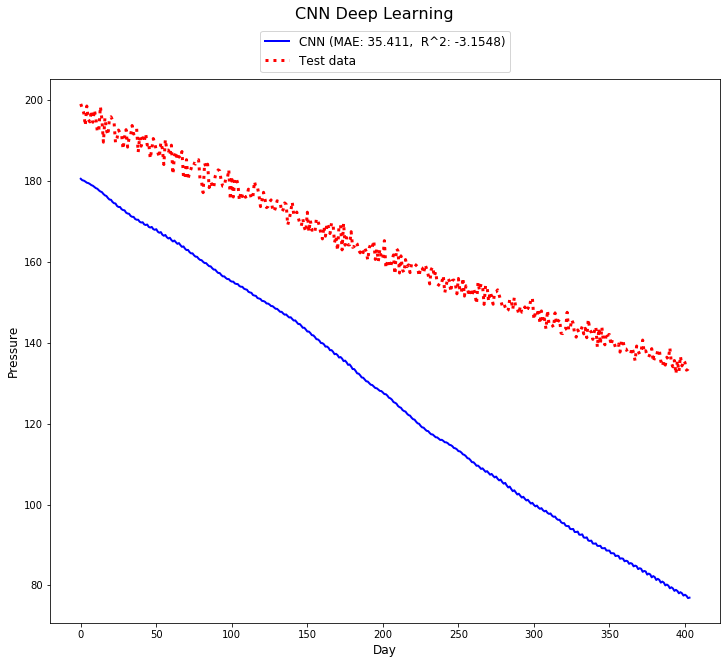

In [169]:
CNN_comp_plot("CNN",
             y_test_single,
             predictions,
             "Day",
             "Pressure",
             "CNN Deep Learning")